# **BERT-MODEL**

**1) Importing Libraries**

In [ ]:
#!pip uninstall torch torchvision torchaudio
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#!pip install nltk rouge-score
#!pip uninstall tensorflow

In [ ]:
import torch
import transformers

print(torch.__version__)
print(transformers.__version__)

2.3.0+cu121
4.40.2


In [ ]:
print(torch.version.cuda)
print(torch.cuda.device_count())

12.1
1


In [ ]:
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
nltk.download('stopwords' , quiet=True)
nltk.download('wordnet', quiet=True)

from sklearn.model_selection import train_test_split

from simpletransformers.question_answering import QuestionAnsweringModel , QuestionAnsweringArgs

import sklearn
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

**2) Importing Data Set**

In [15]:
df = pd.read_csv("train.csv" , keep_default_na=False)

df.head()


,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [16]:
df.shape

(16407, 3)

In [ ]:
df.dtypes

qtype       object
Question    object
Answer      object
dtype: object

In [ ]:
df['qtype'].unique()

array(['susceptibility', 'symptoms', 'exams and tests', 'treatment',
       'prevention', 'information', 'frequency', 'complications',
       'causes', 'research', 'outlook', 'considerations', 'inheritance',
       'stages', 'genetic changes', 'support groups'], dtype=object)

**3) Visualization**

Distribution of Question Types

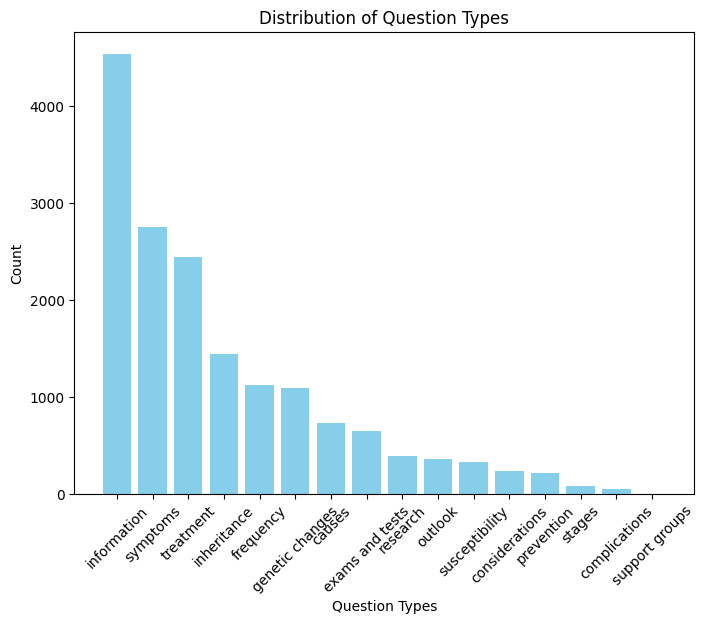

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each question type
question_type_counts = df['qtype'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(question_type_counts.index, question_type_counts.values, color='skyblue')
plt.xlabel('Question Types')
plt.ylabel('Count')
plt.title('Distribution of Question Types')
plt.xticks(rotation=45)
plt.show()


Propotion of Question Types

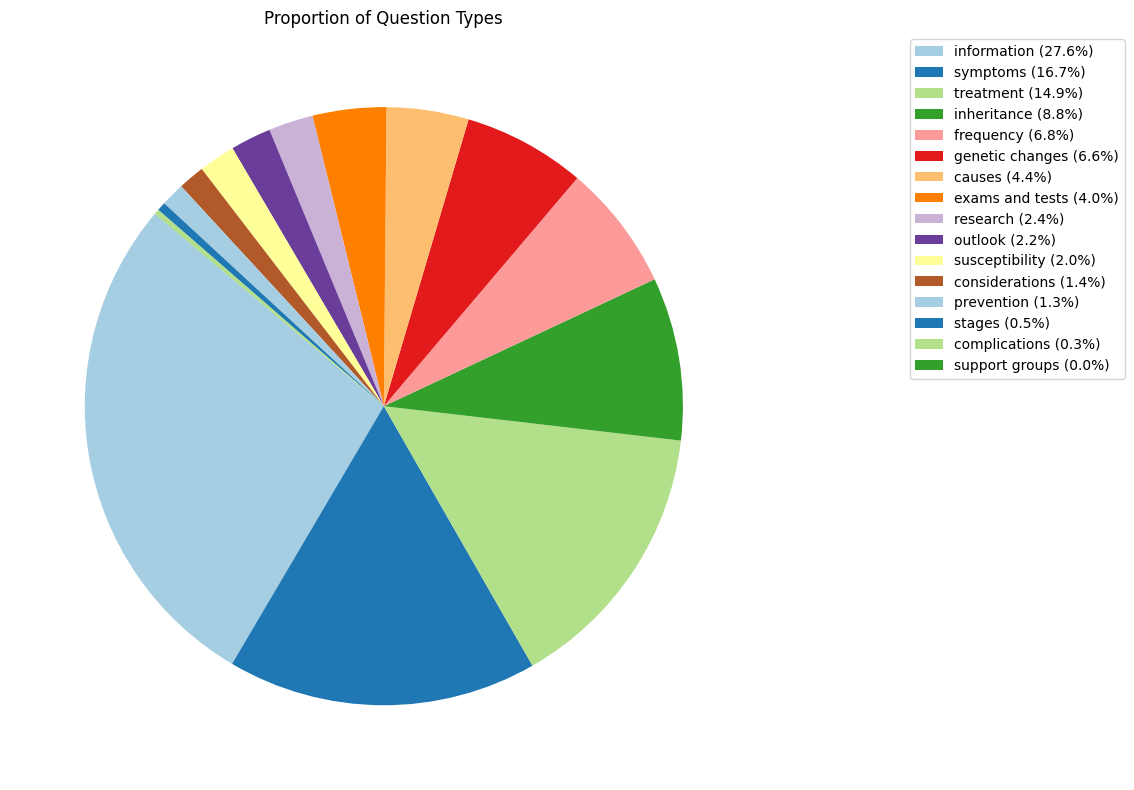

In [14]:
import matplotlib.pyplot as plt

# Count the occurrences of each question type
question_type_counts = df['qtype'].value_counts()

# Calculate the percentages for the legend
percentages = 100 * question_type_counts.values / question_type_counts.values.sum()

# Create the labels with percentages for the legend
labels_with_percentages = [f'{label} ({percent:.1f}%)' for label, percent in zip(question_type_counts.index, percentages)]

plt.figure(figsize=(10, 8))  # Increase the figure size

plt.pie(question_type_counts.values, startangle=140, colors=plt.cm.Paired.colors)
plt.title('Proportion of Question Types')

# Add a legend outside the pie chart
plt.legend(labels_with_percentages, loc="best", bbox_to_anchor=(1, 0.5, 0.5, 0.5))

plt.tight_layout()  # Adjust layout to fit everything
plt.show()



Keywords in Answer Column

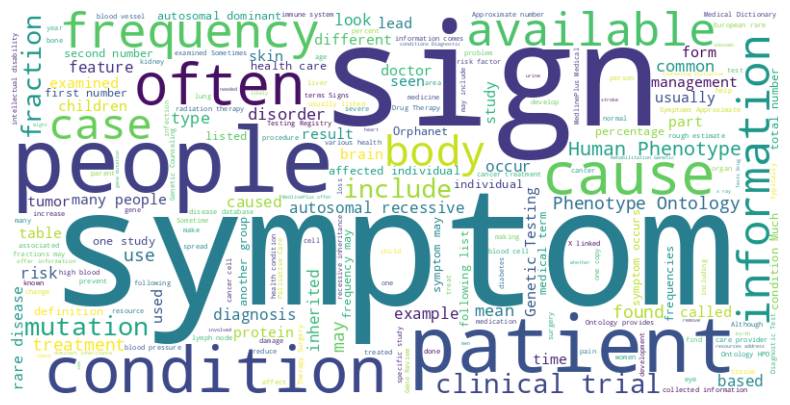

In [6]:
from wordcloud import WordCloud

# Concatenate all answers into a single string
text = " ".join(answer for answer in df['Answer'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Frequency of Keywords in Answer Column

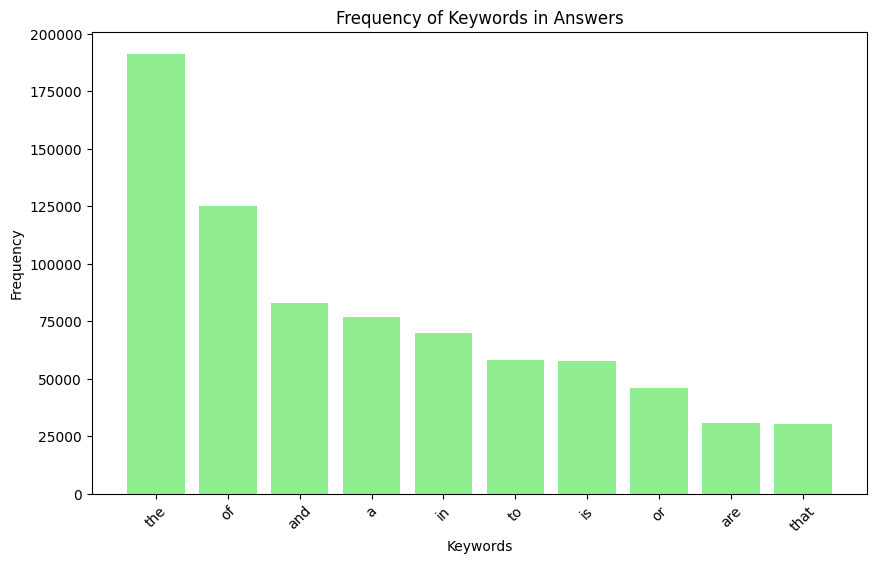

In [7]:
from collections import Counter
import re

# Extract words from the answers
words = re.findall(r'\w+', text.lower())
# Count word frequencies
word_freq = Counter(words)

# Select the most common words
common_words = word_freq.most_common(10)
terms = [item[0] for item in common_words]
frequencies = [item[1] for item in common_words]

plt.figure(figsize=(10, 6))
plt.bar(terms, frequencies, color='lightgreen')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Keywords in Answers')
plt.xticks(rotation=45)
plt.show()


**4) Data Preprocessing**

In [ ]:
def preprocess(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)

    text = text.lower()

    text = ''.join([c for c in text if c.isalnum() or c.isspace()])

    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split() if word not in stop_words])

    text = ' '.join(text.split())
    return text.strip()


In [ ]:
df['Answer'] = df['Answer'].apply(preprocess)
df['Question'] = df['Question'].apply(preprocess)

df.head()

,qtype,Question,Answer
0,susceptibility,risk lymphocytic choriomeningitis lcm,lcmv infections occur exposure fresh urine dro...
1,symptoms,symptoms lymphocytic choriomeningitis lcm,lcmv commonly recognized causing neurological ...
2,susceptibility,risk lymphocytic choriomeningitis lcm,individuals ages come contact urine feces sali...
3,exams and tests,diagnose lymphocytic choriomeningitis lcm,first phase disease common laboratory abnormal...
4,treatment,treatments lymphocytic choriomeningitis lcm,aseptic meningitis encephalitis meningoencepha...


In [ ]:
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.shape

df2 = df.sample(500)

from collections import defaultdict

qtype_ans = defaultdict(list)
for _, row in df2.iterrows():
  qtype_ans[row["qtype"]].append(row["Answer"])

qtype_context = {qtype: " ".join(answers) for qtype, answers in qtype_ans.items()}

train_data, test_data = train_test_split(df2, test_size=0.3, random_state=10)


**5) Create Question Answering Examples**

In [ ]:
train_examples = []
for _, row in train_data.iterrows():
    question = row["Question"]
    answer = row["Answer"]
    qtype = row["qtype"]
    context = qtype_context.get(qtype, "")
    ansstart = context.find(answer)
    qa_data = {
        "context": context,
        "qas": [
            {
                "id": str(row.name),
                "question": question,
                "answers": [{"text": answer, "answer_start": ansstart}],  # Empty list for answers
            }
        ]
    }

    train_examples.append(qa_data)

test_examples = []
for _, row in test_data.iterrows():
    question = row["Question"]
    answer = row["Answer"]
    qtype = row["qtype"]
    context = qtype_context.get(qtype, "")  # Assuming context is not present (modify if available)
    ansstart = context.find(answer)
    qa_data = {
        "context": context,
        "qas": [
            {
                "id": str(row.name),
                "question": question,
                "answers": [{"text": answer, "answer_start": ansstart}] ,  # Empty list for answers
            }
        ]
    }
    test_examples.append(qa_data)

print(len(train_examples))
print(len(test_examples))

print(train_examples[0])
print(test_examples[0])


350
150
{'context': 'autoimmune hemolytic anemia inherited many cases cause autoimmune hemolytic anemia remains unknown researchers believe multiple factors involved including genetic environmental influences multifactorial small number cases autoimmune hemolytic anemia appears run families cases appears follow autosomal recessive pattern inheritance concerns specific risks family encourage consult genetics professional cases myasthenia gravis inherited occurs people history disorder family percent affected individuals family members myasthenia gravis autoimmune disorders inheritance pattern unknown condition inherited autosomal recessive pattern means copies gene cell mutations parents individual autosomal recessive condition carry one copy mutated gene typically show signs symptoms condition hepatic encephalopathy inherited hepatic encephalopathy inherited condition individual cannot pass hisher children brought chronic liver failure particularly alcoholics cirrhosis although many th

**6) Model Configuration**

In [ ]:
import wandb
wandb.init(project="qa-training")

model_args = QuestionAnsweringArgs(
    output_dir="outputs",
    overwrite_output_dir = True,
    # Training arguments
    num_train_epochs=1,
    save_steps=1000,
    logging_steps=100,
    learning_rate=2e-5,
    warmup_steps=200,
    use_multiprocessing = False,

    use_early_stopping=False,
    early_stopping_metric="eval_loss",
    early_stopping_delta=0.001,


    max_seq_length=384,
    doc_stride=128,
    n_best_size=5,
    max_answer_length=30,
    wandb_project="qa_training"
)


In [ ]:
def log(model, train_data, eval_data):
        model.train_model(train_data , acc = sklearn.metrics.accuracy_score)

        eval_results, outputs  = model.eval_model(eval_data , acc = sklearn.metrics.accuracy_score)
        print(eval_results)
        wandb.log({
            "eval_loss": eval_results['eval_loss'],
            "correct": eval_results['correct'],
            "smiliar": eval_results['similar'],
            "incorrect": eval_results['incorrect'],
            "accuracy" : eval_results['acc'],
        })

model_bert = QuestionAnsweringModel(
  "bert", "bert-base-uncased",
  args=model_args,
  use_cuda=True,
)

print("Starting training...")
log(model_bert, train_examples, test_examples)

#the code threw an error due to insufficient memory on the disk since it is running locally on jupyter notebook. Below is the evaluation done again after
#creating some disk space

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
add example index and unique id: 100%|████████████████████████████████████████████| 350/350 [00:00<00:00, 70179.10it/s]


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/4064 [00:00<?, ?it/s]

INFO:simpletransformers.question_answering.question_answering_model: Training of bert model complete. Saved to outputs.
INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
add example index and unique id: 100%|████████████████████████████████████████████| 150/150 [00:00<00:00, 30073.88it/s]


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 128 vs 0

**7) Model Evaluation**

In [ ]:
eval_results, outputs  = model_bert.eval_model(test_examples , acc = sklearn.metrics.accuracy_score)

print(eval_results)
wandb.log({
            "eval_loss": eval_results['eval_loss'],
            "correct": eval_results['correct'],
            "smiliar": eval_results['similar'],
            "incorrect": eval_results['incorrect'],
            "accuracy" : eval_results['acc'],
        })

INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
add example index and unique id: 100%|████████████████████████████████████████████| 150/150 [00:00<00:00, 30079.63it/s]


Running Evaluation:   0%|          | 0/148 [00:00<?, ?it/s]

{'correct': 0, 'similar': 138, 'incorrect': 12, 'acc': 0.0, 'eval_loss': -7.467931798986487}
